In [36]:
"""
Created on Sat Aug 23 23:54:02 2019

@author: Paras
"""

import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.model_selection import train_test_split as tts
from flair.data import Corpus, Sentence
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, FlairEmbeddings
from typing import List

In [37]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))    
    return df

def import_data(file, encoding='utf-8'):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True, encoding=encoding)
    df = reduce_mem_usage(df)
    return df

def to_IOB(tag):
    if 'U-' in tag:
        tag = tag.replace('U-', 'B-')
    elif 'L-' in tag:
        tag = tag.replace('L-', 'I-')
    
    return tag

def format_tags(tag):
    entities = ['CARDINAL','TIME','DATE','ORDINAL','ORG','MONEY','PERCENT','LANGUAGE','LAW','QUANTITY']
    tag = 'O' if any(entity in tag for entity in entities) else tag
    return tag
    
def map_fire_tags(tag):
    entities = ['PERSON','GPE','-LOC','-FAC','ORG','WORK_OF_ART','EVENT','NORP','PRODUCT']
    tag = tag if any(entity in tag for entity in entities) else 'O'
    tag = 'O' if 'LOCO' in tag else tag
    return tag
    
def preprocess_fire(fire_df):
    fire_df = fire_df.iloc[28:, [0,1,4]]
    fire_df.columns = ['Sentence #', 'Word', 'Tag']
    fire_df.reset_index(inplace=True, drop=True)
    
    # Assign sentence boundaries
    prev = 1
    for i in range(len(fire_df)):
        if type(fire_df.at[i, 'Word']) == str and fire_df.at[i, 'Word'] == '*':
            prev+=1
        elif type(fire_df.at[i, 'Word']) == float and math.isnan(fire_df.at[i, 'Word']):
            prev += 1
        fire_df.at[i, 'Sentence #'] = prev
        
    # removal of excess tags
    fire_df['Tag'] = fire_df['Tag'].apply(lambda tag: map_fire_tags(format_tags(tag)))
    fire_df = fire_df.dropna()
    return fire_df

In [38]:
dataset = import_data('../../../Data/ner-data/ontonotes_raw.csv')

/home/shreyas_n1799/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Memory usage of dataframe is 259.55 MB
Memory usage after optimization is: 52.97 MB
Decreased by 79.6%


In [39]:
df = dataset.iloc[:, [4,5,6,13]]
df.columns = ['Sentence #','Word','POS','Tag']
df.dropna(inplace=True)
df = df.reset_index(drop=True)
for col in df.columns[1:]:
    df[col] = df[col].astype('object')
    
entities = ['CARDINAL','TIME','DATE','ORDINAL','MONEY','PERCENT','LANGUAGE','LAW','QUANTITY']
df['Tag'] = df['Tag'].apply(lambda tag: to_IOB(tag))
df['Tag'] = df['Tag'].apply(lambda tag: 'O' if any(entity in tag for entity in entities) else tag)
df.head()

/home/shreyas_n1799/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Sentence #,Word,POS,Tag
0,0,Like,IN,O
1,1,many,JJ,O
2,2,Heartland,NNP,B-LOC
3,3,states,NNS,O
4,4,",",",",O


In [40]:
prev = 1
for i in range(len(df)-1):
    if df.at[i, 'Sentence #'] > df.at[i+1, 'Sentence #']:
        df.at[i, 'Sentence #'] = prev
        prev += 1
    else:
        df.at[i, 'Sentence #'] = prev

df.at[len(df)-1, 'Sentence #'] = prev

In [41]:
print('Number of sentences in OntoNotes dataset:', df['Sentence #'].nunique())

Number of sentences in OntoNotes dataset: 42010


In [42]:
df.head()

,Sentence #,Word,POS,Tag
0,1,Like,IN,O
1,1,many,JJ,O
2,1,Heartland,NNP,B-LOC
3,1,states,NNS,O
4,1,",",",",O


In [43]:
df['Tag'].unique()

array(['O', 'B-LOC', 'B-GPE', 'B-ORG', 'B-PERSON', 'I-PERSON', 'I-GPE',
       'I-LOC', 'B-NORP', 'I-NORP', 'I-ORG', 'B-FAC', 'B-PRODUCT',
       'B-EVENT', 'I-EVENT', 'I-PRODUCT', 'I-FAC', 'B-WORK_OF_ART',
       'I-WORK_OF_ART'], dtype=object)

In [44]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(), 
                                                           s['POS'].values.tolist(), 
                                                           s['Tag'].values.tolist())]
        self.grouped = self.data.groupby('Sentence #').apply(agg_func)
        self.sentences = [s for s in self.grouped]
        
    def get_next(self):
        try: 
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent += 1
            return s 
        except:
            return None

In [45]:
getter = SentenceGetter(df)
sentences = getter.sentences

In [46]:
def write_to_txt(sentences, filename):
    with open(filename, 'w') as f:
        for sentence in sentences:
            for triplet in sentence:
                word, pos, tag = triplet[0], triplet[1], triplet[2]
                f.write("%s\t%s\t%s\n" % (word,pos,tag))
            f.write('\n')
    print('%s is written to disk.' % filename)

In [47]:
train, test = tts(sentences, test_size=0.2, random_state=2019)
dev, test = tts(test, test_size=0.4, random_state=2019)

In [48]:
print('Length of train:', len(train))
print('Length of dev:', len(dev))
print('Length of test:', len(test))

Length of train: 33608
Length of dev: 5041
Length of test: 3361


In [50]:
# write_to_txt(train, 'train.txt')
# write_to_txt(dev, 'dev.txt')
# write_to_txt(test, 'test.txt')

train.txt is written to disk.
dev.txt is written to disk.
test.txt is written to disk.


## Loading the datasets

In [3]:
columns = {0: 'text', 1: 'pos', 2: 'ner'}

data_folder = './'

# init a corpus using column format, data folder and the names of the train, dev and test files
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='dev.txt',
                              tag_to_bioes='ner')

2019-09-04 16:24:25,015 Reading data from .
2019-09-04 16:24:25,016 Train: train.txt
2019-09-04 16:24:25,017 Dev: dev.txt
2019-09-04 16:24:25,018 Test: test.txt


In [4]:
print(corpus)

Corpus: 33608 train + 5041 dev + 3361 test sentences


In [5]:
tag_type = 'ner'

In [6]:
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
print(tag_dictionary.idx2item)

[b'<unk>', b'O', b'B-PERSON', b'E-PERSON', b'S-GPE', b'S-NORP', b'S-PERSON', b'B-ORG', b'I-ORG', b'E-ORG', b'B-WORK_OF_ART', b'I-WORK_OF_ART', b'E-WORK_OF_ART', b'B-GPE', b'E-GPE', b'I-PERSON', b'B-LOC', b'E-LOC', b'I-GPE', b'S-LOC', b'S-ORG', b'I-LOC', b'B-EVENT', b'I-EVENT', b'E-EVENT', b'S-WORK_OF_ART', b'S-PRODUCT', b'B-FAC', b'I-FAC', b'E-FAC', b'S-FAC', b'B-NORP', b'E-NORP', b'B-PRODUCT', b'I-PRODUCT', b'E-PRODUCT', b'I-NORP', b'S-EVENT', b'<START>', b'<STOP>']


In [7]:
# 4. initialize embeddings
embedding_types: List[TokenEmbeddings] = [
    WordEmbeddings('crawl'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]

embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

In [8]:
# 5. initialize sequence tagger
from flair.models import SequenceTagger

tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True,
                                       )

In [9]:
# 6. initialize trainer
from flair.trainers import ModelTrainer

trainer: ModelTrainer = ModelTrainer(tagger, corpus)

In [10]:
# 7. start training
trainer.train('taggers/',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=3,
              train_with_dev=True,
              embeddings_storage_mode='cpu',
              checkpoint=True)

2019-09-04 16:25:10,992 ----------------------------------------------------------------------------------------------------
2019-09-04 16:25:10,993 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('crawl')
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4396, out_features=4396, bias=True)
  (rnn): LSTM(4396, 256, bidirectional=True)

{'test_score': 0.7103,
 'dev_score_history': [],
 'train_loss_history': [2.2207549030812372,
  1.050492907202007,
  0.8414132010364375],
 'dev_loss_history': []}

In [17]:
from pathlib import Path

checkpoint = tagger.load_checkpoint(Path('taggers/checkpoint.pt'))
trainer = ModelTrainer.load_from_checkpoint(checkpoint, corpus)
trainer.train('taggers/',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150,
              patience=3,
              train_with_dev=True,              
              embeddings_storage_mode='cpu',
              checkpoint=True,
              monitor_train=True,
              monitor_test=True)

2019-09-04 20:17:05,814 loading file taggers/checkpoint.pt
2019-09-04 20:17:10,278 ----------------------------------------------------------------------------------------------------
2019-09-04 20:17:10,280 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('crawl')
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4396, out_features=43

2019-09-04 21:59:00,583 epoch 9 - iter 240/1208 - loss 0.47064843 - samples/sec: 42.34
2019-09-04 22:00:32,636 epoch 9 - iter 360/1208 - loss 0.48074252 - samples/sec: 41.73
2019-09-04 22:02:02,887 epoch 9 - iter 480/1208 - loss 0.48032584 - samples/sec: 42.56
2019-09-04 22:03:32,689 epoch 9 - iter 600/1208 - loss 0.48762348 - samples/sec: 42.77
2019-09-04 22:05:02,480 epoch 9 - iter 720/1208 - loss 0.48301293 - samples/sec: 42.78
2019-09-04 22:06:34,533 epoch 9 - iter 840/1208 - loss 0.48888695 - samples/sec: 41.73
2019-09-04 22:08:06,634 epoch 9 - iter 960/1208 - loss 0.48153398 - samples/sec: 41.70
2019-09-04 22:09:38,526 epoch 9 - iter 1080/1208 - loss 0.47783756 - samples/sec: 41.80
2019-09-04 22:11:10,322 epoch 9 - iter 1200/1208 - loss 0.47840796 - samples/sec: 41.84
2019-09-04 22:11:15,665 ----------------------------------------------------------------------------------------------------
2019-09-04 22:11:15,667 EPOCH 9 done: loss 0.4779 - lr 0.1000
2019-09-04 22:17:40,891 TEST

2019-09-05 00:08:37,061 epoch 15 - iter 0/1208 - loss 0.42033571 - samples/sec: 6112.37
2019-09-05 00:10:06,699 epoch 15 - iter 120/1208 - loss 0.34811050 - samples/sec: 42.85
2019-09-05 00:11:38,758 epoch 15 - iter 240/1208 - loss 0.32476511 - samples/sec: 41.72
2019-09-05 00:13:05,530 epoch 15 - iter 360/1208 - loss 0.32355718 - samples/sec: 44.27
2019-09-05 00:14:36,081 epoch 15 - iter 480/1208 - loss 0.33936822 - samples/sec: 42.42
2019-09-05 00:16:05,161 epoch 15 - iter 600/1208 - loss 0.34316872 - samples/sec: 43.12
2019-09-05 00:17:34,430 epoch 15 - iter 720/1208 - loss 0.34588612 - samples/sec: 43.03
2019-09-05 00:19:07,192 epoch 15 - iter 840/1208 - loss 0.34405145 - samples/sec: 41.41
2019-09-05 00:20:38,271 epoch 15 - iter 960/1208 - loss 0.34687825 - samples/sec: 42.17
2019-09-05 00:22:10,751 epoch 15 - iter 1080/1208 - loss 0.34751899 - samples/sec: 41.53
2019-09-05 00:23:43,575 epoch 15 - iter 1200/1208 - loss 0.34894752 - samples/sec: 41.38
2019-09-05 00:23:48,728 ------

2019-09-05 02:20:51,971 TEST : loss 0.3450475335121155 - score 0.9334
2019-09-05 02:20:52,239 BAD EPOCHS (no improvement): 0
2019-09-05 02:21:16,092 ----------------------------------------------------------------------------------------------------
2019-09-05 02:21:16,984 epoch 21 - iter 0/1208 - loss 0.72872365 - samples/sec: 4325.09
2019-09-05 02:22:49,464 epoch 21 - iter 120/1208 - loss 0.31726072 - samples/sec: 41.53
2019-09-05 02:24:22,693 epoch 21 - iter 240/1208 - loss 0.31460402 - samples/sec: 41.20
2019-09-05 02:25:53,846 epoch 21 - iter 360/1208 - loss 0.29154175 - samples/sec: 42.14
2019-09-05 02:27:25,466 epoch 21 - iter 480/1208 - loss 0.28970417 - samples/sec: 41.92
2019-09-05 02:28:57,367 epoch 21 - iter 600/1208 - loss 0.29006102 - samples/sec: 41.80
2019-09-05 02:30:38,462 epoch 21 - iter 720/1208 - loss 0.29602296 - samples/sec: 38.00
2019-09-05 02:32:10,142 epoch 21 - iter 840/1208 - loss 0.29996647 - samples/sec: 41.90
2019-09-05 02:33:44,348 epoch 21 - iter 960/12

2019-09-05 04:30:25,585 ----------------------------------------------------------------------------------------------------
2019-09-05 04:30:25,586 EPOCH 26 done: loss 0.2580 - lr 0.1000
2019-09-05 04:37:02,588 TEST : loss 0.3587382435798645 - score 0.9344
2019-09-05 04:37:02,856 BAD EPOCHS (no improvement): 1
2019-09-05 04:37:26,140 ----------------------------------------------------------------------------------------------------
2019-09-05 04:37:26,957 epoch 27 - iter 0/1208 - loss 0.11909366 - samples/sec: 4720.37
2019-09-05 04:39:02,023 epoch 27 - iter 120/1208 - loss 0.26396047 - samples/sec: 40.41
2019-09-05 04:40:35,313 epoch 27 - iter 240/1208 - loss 0.24190467 - samples/sec: 41.17
2019-09-05 04:42:09,651 epoch 27 - iter 360/1208 - loss 0.24801432 - samples/sec: 40.72
2019-09-05 04:43:47,787 epoch 27 - iter 480/1208 - loss 0.25231780 - samples/sec: 39.14
2019-09-05 04:45:23,324 epoch 27 - iter 600/1208 - loss 0.25202380 - samples/sec: 40.21
2019-09-05 04:46:56,932 epoch 27 -

{'test_score': 0.9306,
 'dev_score_history': [],
 'train_loss_history': [tensor(0.3366),
  tensor(0.3018),
  tensor(0.2776),
  tensor(0.2352),
  tensor(0.2143),
  tensor(0.2087),
  tensor(0.1876),
  tensor(0.1663),
  tensor(0.1696),
  tensor(0.1517),
  tensor(0.1339),
  tensor(0.1248),
  tensor(0.1224),
  tensor(0.1170),
  tensor(0.1028),
  tensor(0.1002),
  tensor(0.0960),
  tensor(0.0893),
  tensor(0.0877),
  tensor(0.0780),
  tensor(0.0764),
  tensor(0.0674),
  tensor(0.0691),
  tensor(0.0606),
  tensor(0.0598)],
 'dev_loss_history': []}

In [62]:
tag_counts = {}
for row in test:
    for word in row:
        if word[2] != 'O':
            tag_val = word[2]            
            if tag_val[2:] in tag_counts:
                tag_counts[tag_val[2:]] += 1
            else:
                tag_counts[tag_val[2:]] = 1            

In [63]:
tag_counts

{'GPE': 1215,
 'FAC': 146,
 'ORG': 1470,
 'PERSON': 1582,
 'EVENT': 129,
 'NORP': 403,
 'LOC': 167,
 'PRODUCT': 68,
 'WORK_OF_ART': 172}

Weights plots are saved in taggers/weights.png


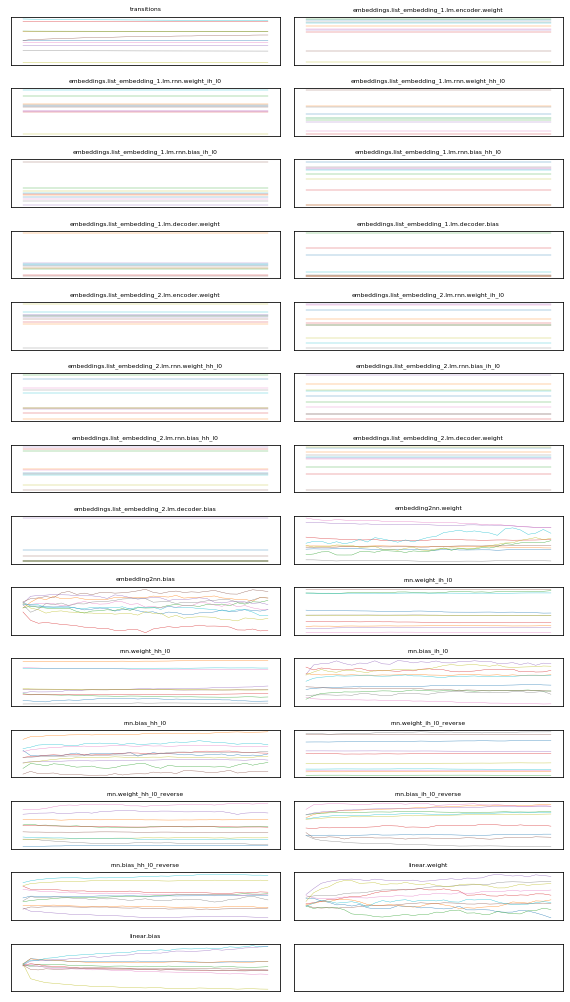

In [11]:
# 8. plot weight traces (optional)
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_weights('taggers/weights.txt')

In [19]:
model = SequenceTagger.load('taggers/final-model.pt')

2019-09-05 06:00:55,727 loading file taggers/final-model.pt
Fissures in Hurriyat <S-ORG> over Pakistan <S-GPE> visit


In [26]:
text = ['Status quo will not be disturbed at Ayodhya; says Vajpayee',
        'Fissures in Hurriyat over Pakistan visit',
        "Car dealers caught in Bihar sales tax ruling"]

for t in text:
    sentence = Sentence(t)
    model.predict(sentence)
    print(sentence.to_tagged_string())

Status quo will not be disturbed at Ayodhya; <S-PERSON> says Vajpayee <S-PERSON>
Fissures in Hurriyat <S-ORG> over Pakistan <S-GPE> visit
Car dealers caught in Bihar <S-GPE> sales tax ruling
